# Food Recommendation Project

This Project called **Masaku** (Masak Sisa Bahan di Kulkas) is a Flask App that will recommend you what to cook based on what is left on your fridge using Content-Based Filtering. The dataset used for the recommendation is from [Kaggle](https://www.kaggle.com/canggih/indonesian-food-recipes) Indonesian Food Recipes by scraping the data from [Cookpad](https://www.cookpad.com). You can easily choose what's your main dish and input another supporting ingredients to cook it and the app will give you five recommendation.

## 1. The Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import sys
from collections import OrderedDict
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

### 1.1 Preparing The Data

There are six different group of receipt available: **Chicken**, **Fish**, **Egg**, **Tahu**, **Tempe**, and **Meat**.

In [2]:
data_ayam=pd.read_csv('dataset-ayam.csv')
data_ayam['category']='ayam'
data_ikan=pd.read_csv('dataset-ikan.csv')
data_ikan['category']='ikan'
data_telur=pd.read_csv('dataset-telur.csv')
data_telur['category']='telur'
data_tahu=pd.read_csv('dataset-tahu.csv')
data_tahu['category']='tahu'
data_tempe=pd.read_csv('dataset-tempe.csv')
data_tempe['category']='tempe'
data_sapi=pd.read_csv('dataset-sapi.csv')
data_sapi['category']='sapi'
data=pd.concat([data_ayam,data_ikan,data_telur,data_tahu,data_tempe,data_sapi], ignore_index=True)

The Data Above contains so many duplicate data, so i drop the duplicates data from each dataset

In [3]:
data.drop_duplicates(subset='Title',inplace=True)

In [4]:
len(data)

9487

In [5]:
data.isnull().sum()

Title          0
Ingredients    3
Steps          1
Loves          0
URL            0
category       0
dtype: int64

Because it's only a little amount of missing data, i decided to drop it anyway

In [6]:
data.dropna(inplace=True)

In [7]:
len(data)

9484

In [8]:
data.head()

,Title,Ingredients,Steps,Loves,URL,category
0,Ayam Woku Manado,1 Ekor Ayam Kampung (potong 12)--2 Buah Jeruk ...,Cuci bersih ayam dan tiriskan. Lalu peras jeru...,1,/id/resep/4473027-ayam-woku-manado,ayam
1,Ayam goreng tulang lunak,1 kg ayam (dipotong sesuai selera jangan kecil...,"Haluskan bumbu2nya (BaPut, ketumbar, kemiri, k...",1,/id/resep/4471956-ayam-goreng-tulang-lunak,ayam
2,Ayam cabai kawin,1/4 kg ayam--3 buah cabai hijau besar--7 buah ...,Panaskan minyak di dalam wajan. Setelah minyak...,2,/id/resep/4473057-ayam-cabai-kawin,ayam
3,Ayam Geprek,250 gr daging ayam (saya pakai fillet)--Secuku...,Goreng ayam seperti ayam krispi--Ulek semua ba...,10,/id/resep/4473023-ayam-geprek,ayam
4,Minyak Ayam,400 gr kulit ayam & lemaknya--8 siung bawang p...,Cuci bersih kulit ayam. Sisihkan--Ambil 50 ml ...,4,/id/resep/4427438-minyak-ayam,ayam


In [9]:
data.to_csv('C:/Users/ACER/Documents/FINAL PROJECT/data_full.csv',index=False)

For The Analysis, the variable needed are only name of the food (Title), Ingredients, and Category. But, add the Ingredients later.

In [10]:
df=data[['Title','category']]

### 1.2 Cleaning The Text

Cleaning the ingredients words from **number**, **punctuation**, **double spacing**, and **lowering** all of them

In [11]:
Ingredients=[]
for i in data['Ingredients']:
    lower=i.lower()
    number=re.sub("\d"," ",lower)
    punct=re.sub(r"[^\w\s]"," ",number)
    space=re.sub(r"\s+"," ",punct)
    Ingredients.append(space)
df['Ingredients']=Ingredients

c:\users\acer\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Stemming aims to transform words into their basic words by **removing** all word affixes including word **prefixes**, word insertions (**infixes**), word **suffixes** and or eliminating word prefixes in derived words. I am using Sastrawi module to manage affixes in Bahasa Indonesia.

In [12]:
#Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
datastemmed = map(lambda x: stemmer.stem(x),
Ingredients)
datastemmed = list(Ingredients)

In [13]:
df['Ingredients']=datastemmed

c:\users\acer\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
df.head()

,Title,category,Ingredients
0,Ayam Woku Manado,ayam,ekor ayam kampung potong buah jeruk nipis sdm...
1,Ayam goreng tulang lunak,ayam,kg ayam dipotong sesuai selera jangan kecil y...
2,Ayam cabai kawin,ayam,kg ayam buah cabai hijau besar buah cabai mer...
3,Ayam Geprek,ayam,gr daging ayam saya pakai fillet secukupnya g...
4,Minyak Ayam,ayam,gr kulit ayam lemaknya siung bawang putih kat...


It's difficult to deal with people's style of writing, sometimes they did abbreviation or typo. So i made a bunch of common typo and abbreviation dictionary, to solve it by replacing it. I also added Indonesian stopwords to eliminate some meaningless words in Bahasa Indonesia.

In [15]:
sinonim = {}
with open("synonim.txt") as file:
    for line in file:
       (key, val) = line.split(":")
       sinonim[key] = val.replace("\n","")

stopwords=open('stopwords_id.txt','r').read()
sinonim

{' dr ': ' dari ',
 'aluminium': 'alumunium',
 'ambik': 'ambil',
 'cabe': 'cabai',
 'cabee': 'cabai',
 'cabeh': 'cabai',
 'cabenya': 'cabai',
 'caberawit': 'cabai rawit',
 'cabet': 'cabai',
 'cabait': 'cabai',
 'cabaix': 'cabai',
 'cabau': 'cabai',
 'caos': 'saos',
 'chedar': 'keju',
 'cheddar': 'keju',
 'cheedar': 'keju',
 'chees': 'keju',
 'cheese': 'keju',
 'chicken': 'keju',
 'chiken': 'ayam',
 'cmjahe': 'jahe',
 'bangkuang': 'bengkoang',
 'barbaque': 'barbeque',
 'barbecue': 'barbeque',
 'baso': 'bakso',
 'bawamg': 'bawang',
 'bawang': 'bawang',
 'bawangbombai': 'bawang bombai',
 'bawangmerah': 'bawang merah',
 'bawangprei': 'bawang prei',
 'bawangputih': 'bawang putih',
 'bawanh': 'bawang',
 'bawanng': 'bawang',
 'bawanv': 'bawang',
 'bawmer': 'bawang merah',
 'bawnag': 'bawang',
 'bawng': 'bawang',
 'bawput': 'bawang putih',
 'blackpaper': 'blackpepper',
 'blackpapper': 'blackpepper',
 'blimbing': 'belimbing',
 'blimbling': 'belimbing',
 'bndeng': 'bandeng',
 'dagingny': 'daging

In [16]:
def replace_all(data, dic):
    for i, j in dic.items():
        data = data.replace(i, j)
    return data
dic = OrderedDict(sinonim)

datachange = []
for line in df['Ingredients']:
    result = replace_all(line, dic)
    datachange.append(result)
    
df['Ingredients']=datachange

c:\users\acer\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [17]:
resepfinal=[]
for line in datachange:
    word_token = word_tokenize(line)
    word_token = [word for word in word_token if not word in stopwords and not word[0].isdigit()]
    resepfinal.append(" ".join(word_token))

I got my final data:

In [18]:
df['Ingredients']=resepfinal

c:\users\acer\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 2. Let's Find Out What You Should Cook!

To achieve what i aim for, i made an input variable to ask what main dish do you want to cook and supporting ingredients left on your fridge. I stored the answer as **'Data Input'** and **Ingredients** so that i can using **Content-Based Filtering** Method.

In [19]:
cat=str(input('Masukkan Bahan Utama (Ayam, Ikan, Telur, Tahu, Tempe) : ')).lower()
new=str(input('Masukkan Bahan Pendukung (Pisahkan dengan Koma) : ')).lower()

if cat=="ayam":
    dataresep=df[df['category']=='ayam']
elif cat=='ikan':
    dataresep=df[df['category']=='ikan']
elif cat=='telur':
    dataresep=df[df['category']=='telur']
elif cat=='tahu':
    dataresep=df[df['category']=='tahu']
elif cat=='tempe':
    dataresep=df[df['category']=='tempe']
elif cat=='sapi':
    dataresep=df[df['category']=='sapi']
dataresep=dataresep[dataresep['Title']!='Data Input']
dataresep=dataresep.append({'Title':'Data Input','Ingredients':new}, ignore_index=True)

Masukkan Bahan Utama (Ayam, Ikan, Telur, Tahu, Tempe) : Ayam
Masukkan Bahan Pendukung (Pisahkan dengan Koma) : Bawang Putih, Bawang Merah, Lengkuas, Sereh, Seledri, Kecap


In [20]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataresep['Ingredients'])
# print(count_matrix)

In [21]:
cv.get_feature_names()

['abaikan',
 'abc',
 'abon',
 'acar',
 'aci',
 'acting',
 'acv',
 'adas',
 'adon',
 'adonan',
 'aduk',
 'aida',
 'air',
 'airnya',
 'ajah',
 'ajh',
 'ajinomoto',
 'akarnya',
 'alas',
 'all',
 'alluminium',
 'alumunium',
 'ambu²',
 'amis',
 'amisnya',
 'ampela',
 'ampla',
 'angciu',
 'anget',
 'angkak',
 'angkat',
 'angsa',
 'anise',
 'apel',
 'aq',
 'arah',
 'arak',
 'arik',
 'arinya',
 'aroma',
 'asam',
 'asem',
 'asim',
 'asli',
 'aslinya',
 'asparagus',
 'ati',
 'ato',
 'atoom',
 'atw',
 'awang',
 'aweuh',
 'ayah',
 'ayam',
 'ayap',
 'baberque',
 'baby',
 'bacem',
 'backing',
 'badan',
 'bagus',
 'bagusnya',
 'bahagian',
 'bahan',
 'bahan²',
 'bajak',
 'bakar',
 'bakaran',
 'baking',
 'bakmoy',
 'bakpao',
 'bakso',
 'bakwan',
 'balada',
 'balok',
 'balungan',
 'baluran',
 'balutan',
 'bamboe',
 'bambu',
 'bamer',
 'band',
 'banding',
 'bandot',
 'bangau',
 'banget',
 'banggo',
 'bangka',
 'bangkok',
 'bango',
 'banyakin',
 'banyaknya',
 'baput',
 'barbeque',
 'barco',
 'baris',
 'ba

Compute Cosine Similarity to find out how similar Data Input to another receipt available.

In [22]:
cosine_sim= cosine_similarity(count_matrix)

In [23]:
indexinput=dataresep[dataresep['Title']== 'Data Input'].index.values[0]
food=list(enumerate(cosine_sim[indexinput]))

In [24]:
sortfood=sorted(food, key=lambda i:i[1], reverse=True)

These are your five recomendation food to cook based on what its left on your fridge with their similarity value:

In [25]:
rekomendasi=[]
for i in sortfood[:6]:
    if dataresep.iloc[i[0]]['Title']!='Data Input':
        print('Food:',dataresep.iloc[i[0]]['Title'],i[1])
        rekomendasi.append(dataresep.iloc[i[0]]['Title'])

Food: Asem-Asem Sayap ayam 0.6567672978933174
Food: Ayam cabe manis ~Leana 0.6414269805898186
Food: Oseng ati ampela ayam 0.6363961030678927
Food: Ayam gongso pedassss 0.5838742081211422
Food: Gongso ayam + telur 0.5813776741499453


## 3. Visualization

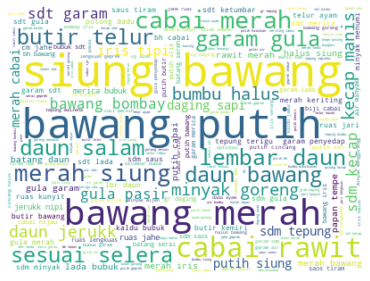

In [26]:
text = df.Ingredients
# plt.figure(figsize=(12,9))
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white", width=400, height=300).generate(' '.join(text))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

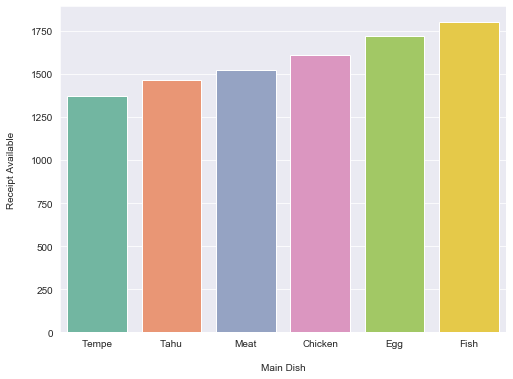

In [29]:
label=("Tempe","Tahu","Meat","Chicken","Egg","Fish")
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.countplot(x='category', data=df, palette="Set2", order=df['category'].value_counts(ascending=True).index)
plt.xlabel('\nMain Dish')
plt.ylabel('Receipt Available\n')
plt.xticks(np.arange(6),labels=label)
plt.show()